<a href="https://colab.research.google.com/github/Mohammed159159/SmartElectricity/blob/master/Demand_Forecasting_Using_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Getting Started

**Steps:**
1. Understanding the Data
2. Removing Noise

    a. Checking for non-stationarity using Augmented Dickey-Fuller Test(trends and seasonality)

    b. Removing non-stationarity using regression and differencing

3. Building Model

    a. Finding best parameters for the Model

    b. Using Autoregrissive Integrated Moving Average (ARIMA)
4. Prediction





In [ ]:
#import necessary libraries
!pip install chart_studio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

In [218]:
#reading and organizing the dataset
df = pd.read_csv("/content/Electric_Production.csv")
df.columns = ["Date", "Consumption"]
df = df.dropna()
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace = True)
df

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


# 1. Understanding the Data

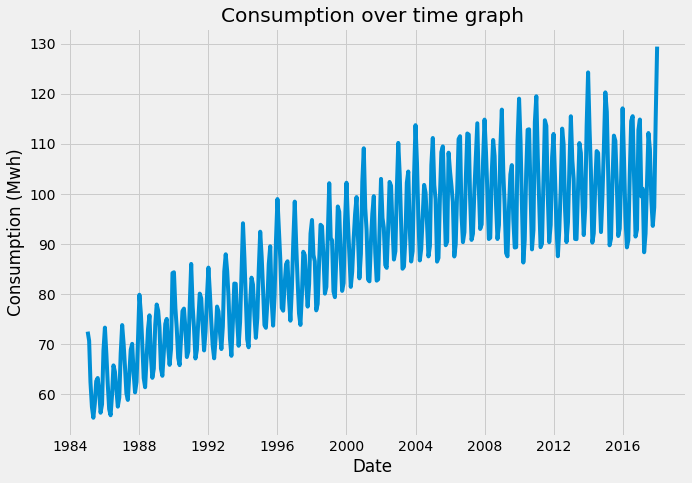

In [219]:
#plotting current data
plt.xlabel("Date")
plt.ylabel("Consumption (Mwh)")
plt.title("Consumption over time graph")
plt.plot(df)

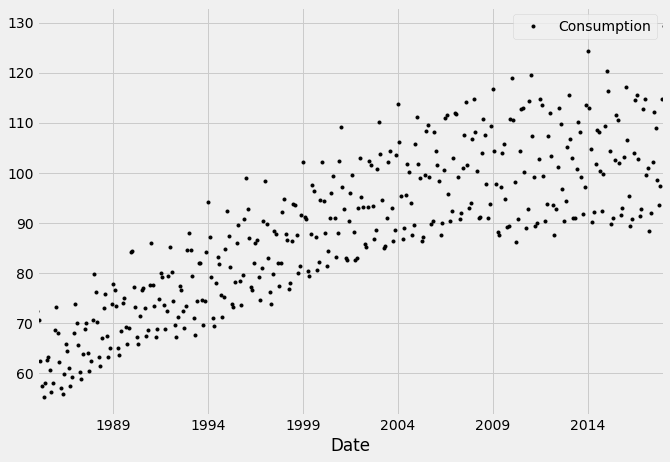

In [220]:
#scatter plot
df.plot(style="k.")
plt.show()

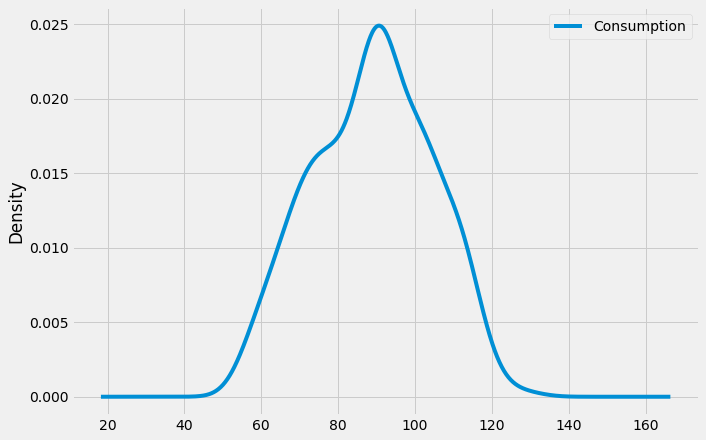

In [221]:
#consumption distribution
df.plot(kind = "kde")

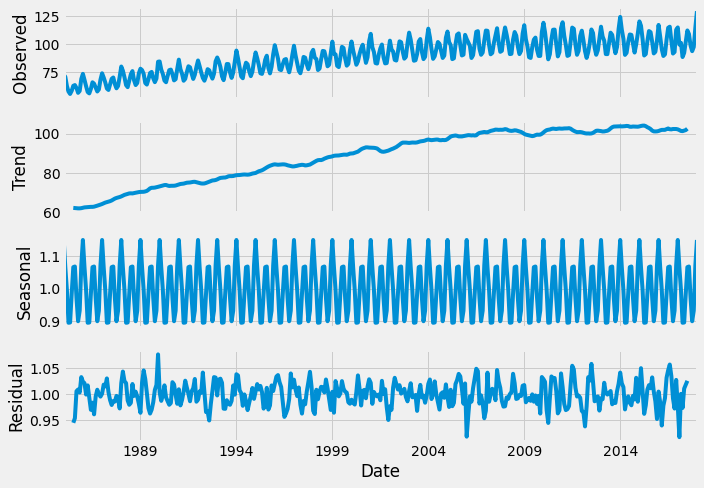

In [222]:
#plotting systematic components (patterns)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model="multiplicative")
result.plot()
plt.show()

# 2. Removing Noise 

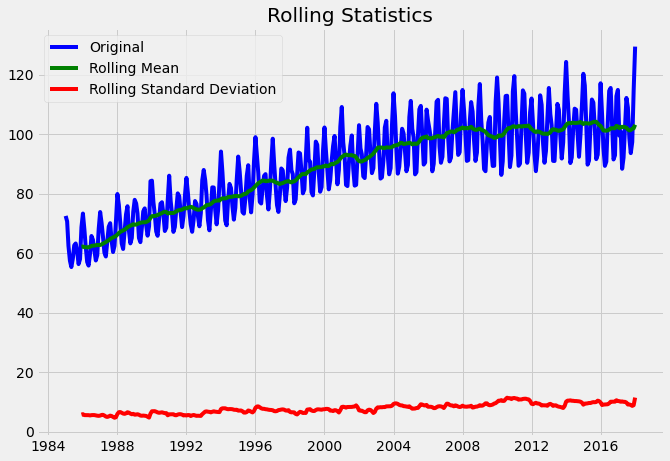

,Augmented Dickey-Fuller Test Results
Test Statistics,-2.256990
p-value,0.186215
No. of Lags Used,15.000000
Number of Observations Used,381.000000
Critical value (1%),-3.447631
Critical value (5%),-2.869156
Critical value (10%),-2.570827


In [223]:
#detecting non-stationarity using Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
def detect_nonstationarity(timeseries):
  #determining rolling statistics
  rollmean = timeseries.rolling(12).mean()
  rollsd = timeseries.rolling(12).std()
  #plotting rolling statistics
  plt.plot(timeseries, label = "Original", color = "blue")
  plt.plot(rollmean, label = "Rolling Mean", color = "green")
  plt.plot(rollsd, label = "Rolling Standard Deviation", color = "red")
  plt.legend(loc = "best")
  plt.title("Rolling Statistics")
  plt.show(block = False)
  #performing adf test
  adf = adfuller(timeseries["Consumption"], autolag = "AIC")
  output = pd.Series(data = adf[0:4], index = ["Test Statistics", "p-value", 
                                              "No. of Lags Used",
                                              "Number of Observations Used"])
  for key, value in adf[4].items():
    output["Critical value ({})".format(key)] = value
    
  output = output.to_frame()
  output.columns = ["Augmented Dickey-Fuller Test Results"]
  return output
detect_nonstationarity(df)

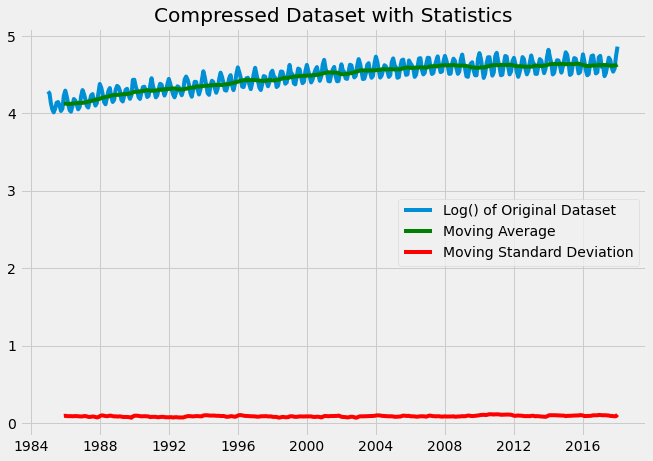

In [224]:
#reducing the magnitude of the dataset
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
moving_sd = df_log.rolling(12).std()
plt.plot(df_log, label = "Log() of Original Dataset")
plt.plot(moving_avg, color = "green", label = "Moving Average")
plt.plot(moving_sd, color = "red", label = "Moving Standard Deviation")
plt.title("Compressed Dataset with Statistics")
plt.legend(loc = "best")
plt.show(block = False)

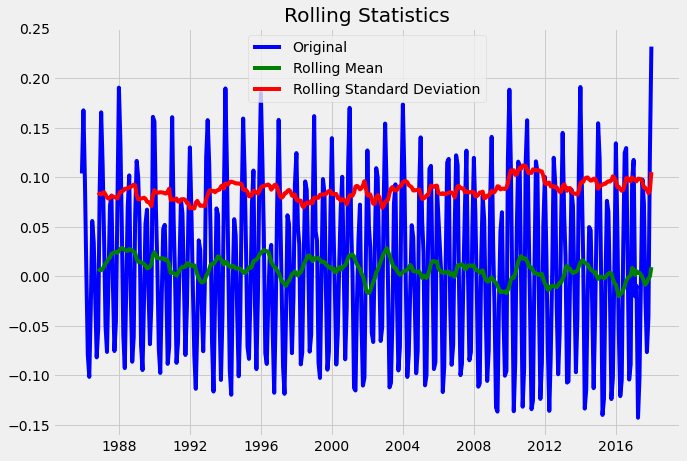

,Augmented Dickey-Fuller Test Results
Test Statistics,-5.211586
p-value,0.000008
No. of Lags Used,15.000000
Number of Observations Used,370.000000
Critical value (1%),-3.448148
Critical value (5%),-2.869383
Critical value (10%),-2.570948


In [225]:
#eliminating trend using differencing and checking for stationarity
df_log_moving_avg_diff = df_log - moving_avg
df_log_moving_avg_diff.dropna(inplace = True)
detect_nonstationarity(df_log_moving_avg_diff)

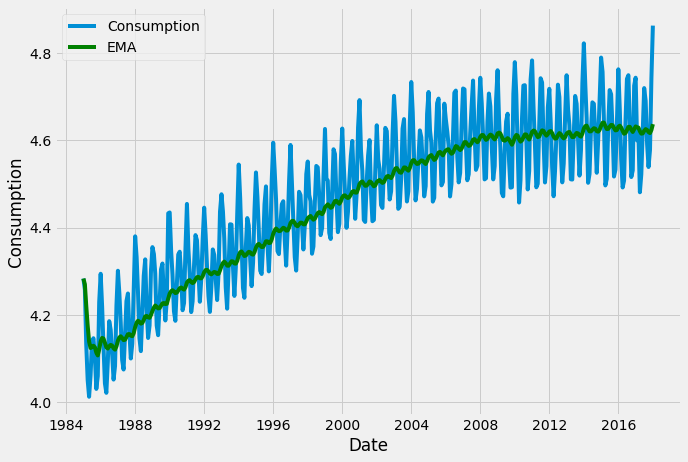

In [226]:
#detecting further trend in the time series by calculating the weighted average (exponential moving average)
ema = df_log.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
plt.plot(df_log, label = "Consumption")
plt.plot(ema, label = "EMA", color = "green")
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
rcParams["figure.figsize"] = 10, 6
plt.legend(loc = "best")
plt.show(block = False)

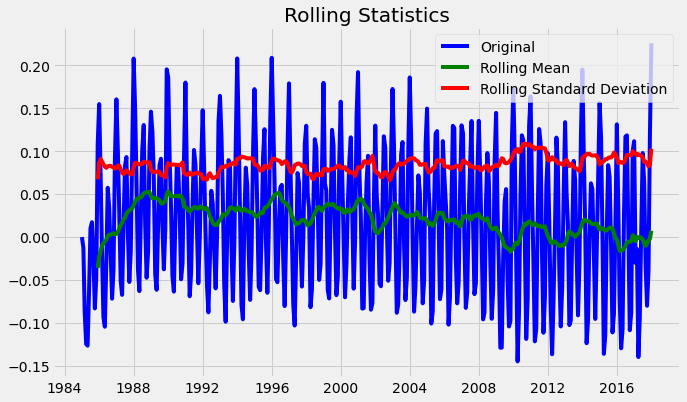

,Augmented Dickey-Fuller Test Results
Test Statistics,-3.251531
p-value,0.017189
No. of Lags Used,15.000000
Number of Observations Used,381.000000
Critical value (1%),-3.447631
Critical value (5%),-2.869156
Critical value (10%),-2.570827


In [227]:
#further removing trend
df_log_w_avg_diff = df_log - ema
rcParams["figure.figsize"] = 10, 6
detect_nonstationarity(df_log_w_avg_diff)

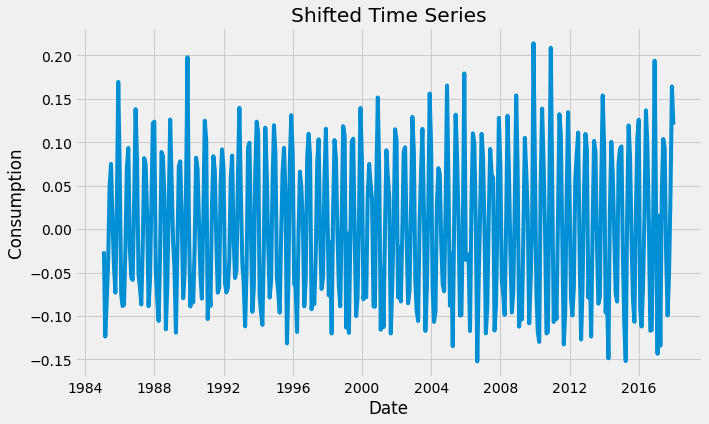

In [228]:
#removing seasonality by differencing (shifting)
df_log_diff = df_log - df_log.shift()
df_log_diff.dropna(inplace = True)
plt.title("Shifted Time Series")
plt.ylabel("Consumption")
plt.xlabel("Date")
plt.plot(df_log_diff)

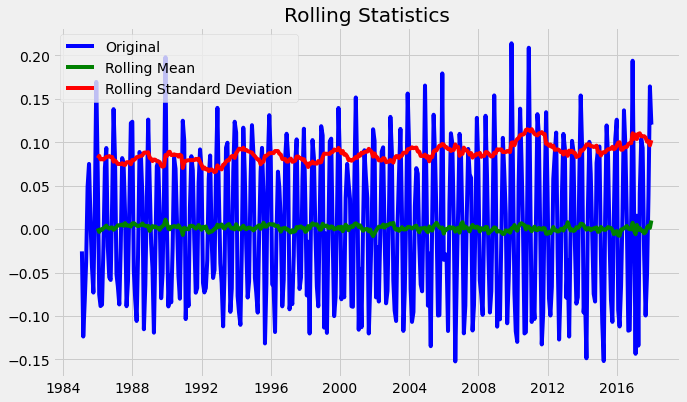

,Augmented Dickey-Fuller Test Results
Test Statistics,-6.748333e+00
p-value,2.995161e-09
No. of Lags Used,1.400000e+01
Number of Observations Used,3.810000e+02
Critical value (1%),-3.447631e+00
Critical value (5%),-2.869156e+00
Critical value (10%),-2.570827e+00


In [229]:
#testing
detect_nonstationarity(df_log_diff)

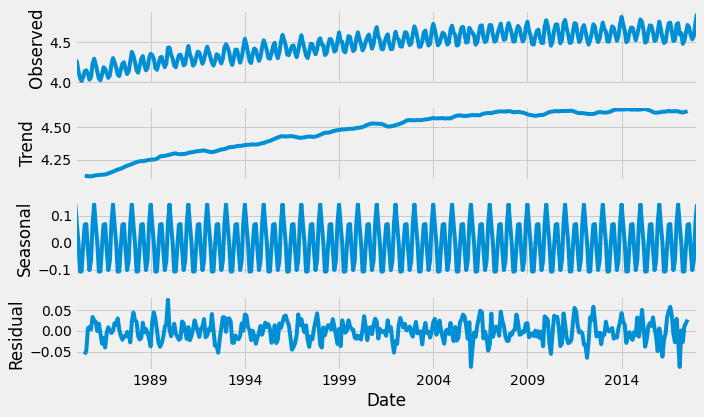

In [230]:
#visualizing stationarized time series
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(df_log, model="additive", freq = 12)
result.plot()
plt.show()

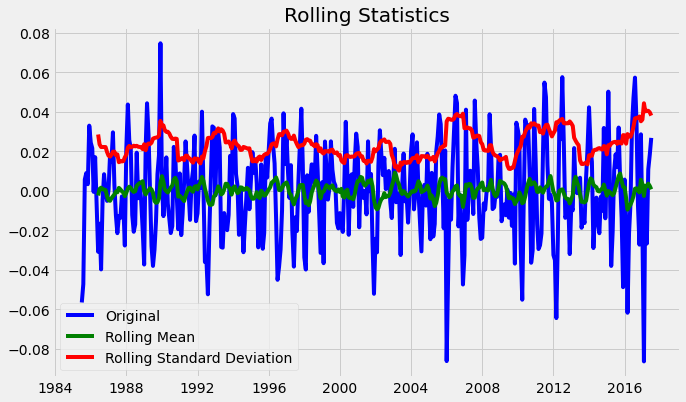

,Augmented Dickey-Fuller Test Results
Test Statistics,-1.000311e+01
p-value,1.861632e-17
No. of Lags Used,1.400000e+01
Number of Observations Used,3.700000e+02
Critical value (1%),-3.448148e+00
Critical value (5%),-2.869383e+00
Critical value (10%),-2.570948e+00


In [231]:
#final test
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
detect_nonstationarity(residual)

# 3. Establishing Model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partially Autocorrelation Function')

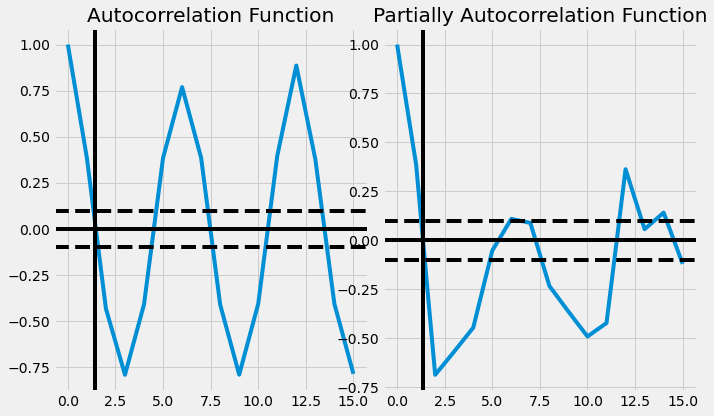

In [232]:
#finding best parameters for the model using AutoCorrelation and PartialCorrelation
from statsmodels.tsa.stattools import pacf, acf
acf = acf(df_log_diff, nlags = 15)
pacf = pacf(df_log_diff, nlags = 15, method = "ols")
#plotting acf
plt.subplot(121)
plt.plot(acf)
plt.axhline(y = 1.96/np.sqrt(len(df_log_diff)), color = "black", linestyle = "--")
plt.axhline(y = 0, color = "black", linestyle = "-")
plt.axvline(x = 1.45, color = "black", linestyle = "-")
plt.axhline(y = -1.96/np.sqrt(len(df_log_diff)), color = "black", linestyle = "--")
plt.title("Autocorrelation Function")
plt.tight_layout()
#plotting pacf
plt.subplot(122)
plt.plot(pacf)
plt.axhline(y = 1.96/np.sqrt(len(df_log_diff)), color = "black", linestyle = "--")
plt.axhline(y = 0, color = "black", linestyle = "-")
plt.axvline(x = 1.35, color = "black", linestyle = "-")
plt.axhline(y = -1.96/np.sqrt(len(df_log_diff)), color = "black", linestyle = "--")
plt.title("Partially Autocorrelation Function")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RSS : 0.014892099888842781


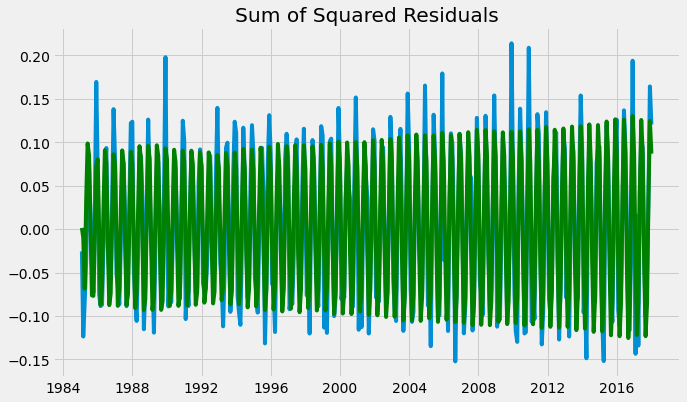

In [233]:
#training model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(2,1,2))
result_AR = model.fit(disp = 0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color = "green")
plt.title("Sum of Squared Residuals")
print("RSS : {}".format(sum(result_AR.fittedvalues - df_log_diff["Consumption"])**2))

# 4. Prediction

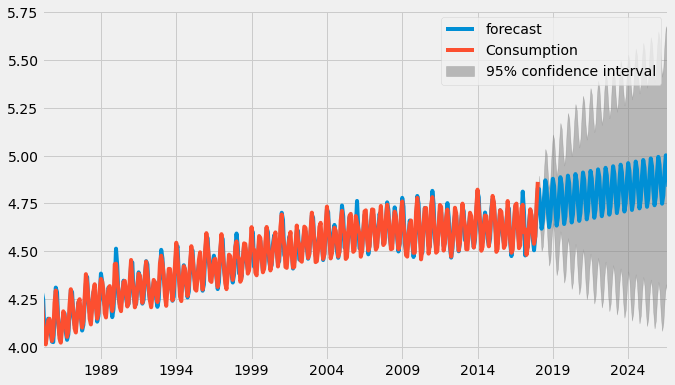

In [234]:
result_AR.plot_predict(1,500)
x = result_AR.forecast(steps = 300)